# Hadamard Test

## Overview

- Type: Quantum gadget and subroutine
- Approachability: Easy
- Prerequisites: Phase kickback
- Postrequisites: Phase estimation, Amplitude estimation

The Hadamard test is a simple circuit for calculating the expectation value of a unitary operator. It takes advantage of phase kickback to encode the expectation value in the amplitudes of a single-qubit auxiliary register. 

## Description

### Pure state

Let $ \langle U \rangle = \langle \psi \vert U \vert \psi \rangle$ be the expectation value of $U$ with respect to a pure state $\vert \psi \rangle$. The algorithm proceeds by measuring the real and imaginary parts of $\langle U \rangle$ by inserting or removing an $S$ gate from the following circuit.

<center>
<img src=Images/Hadamard_Basic.png>  
</center>

#### Real part

After applying the circuit without a phase gate, prior to measurement, the resulting state is 

$$
\vert 0 \rangle \otimes \frac{\vert\psi \rangle + U \vert \psi \rangle}{2} + \vert 1 \rangle \otimes \frac{\vert\psi\rangle - U \vert\psi\rangle}{2}.
$$

The probability $\Pr(0)$ of measuring 'zero' in the first register is given by the Born rule.

$$
\begin{aligned}
\Pr(0) &= \frac14 (2 + \langle U \rangle + \langle U^\dagger \rangle) \\
&= \frac{1 + \mathrm{Re}\langle U \rangle}{2}
\end{aligned}
$$

Here $\mathrm{Re}$ is the real part. Of course, $\Pr(1) = 1- \Pr(0)$. By measuring the circuit $N$ times, the probability $\Pr(0)$, hence $\mathrm{Re} \langle U \rangle$, can be measured to accuracy $O(1/\sqrt{N})$. However, this is not the optimal approach. By using quantum amplitude estimation instead of repeated measurements, a quadratic improvement can be obtained, boosting the accuracy to an optimal $O(1/N)$ known as the 'Heisenberg limit.' 

#### Imaginary part

With the $S$ gate inserted, the final output prior to measurement acquires a factor of $i$ in front of the $U$.

$$
\vert 0 \rangle \otimes \frac{\vert\psi \rangle + i U \vert \psi \rangle}{2} + \vert 1 \rangle \otimes \frac{\vert\psi\rangle - i U \vert\psi\rangle}{2}.
$$

Now, the probability $\Pr(0)$ of measuring 'zero' in the first register is given by

$$
\begin{aligned}
\Pr(0) &= \frac14 (2 + i\langle U \rangle -i \langle U^\dagger \rangle) \\
&= \frac{1 - \mathrm{Im}\langle U \rangle}{2}
\end{aligned}
$$

Thus, the imaginary part can be obtained in an entirely analogous manner: either through repeated measurements or quantum amplitude estimation.

## Qiskit implementation

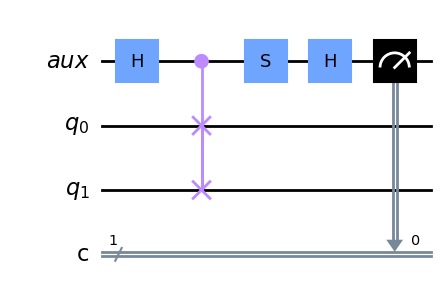

In [27]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit.circuit.library.standard_gates import SwapGate

def Hadamard_circ(U, add_s_gate = False, measure = True):
    
    # Initialize registers and circuit
    aux = QuantumRegister(1, 'aux')
    main = QuantumRegister(U.num_qubits, 'q')
    circuit = QuantumCircuit(aux, main)
    
    # construct controlled-U gate
    cU = U.control(1)
    
    #Add gates to circuit
    circuit.h(aux)
    circuit.append(cU,aux[:] + main[:]) # <----- Weird hack to get the registers to work out.
    if add_s_gate: circuit.s(aux)
    circuit.h(aux)
    
    # Add measurement if option specified
    if measure:
        creg = ClassicalRegister(1, 'c')
        circuit.add_register(creg)
        circuit.measure(aux, creg)
    
    return circuit

circuit = Hadamard_circ(SwapGate(), add_s_gate = True, measure = True)
circuit.draw(output = 'mpl')

## Applications

### Phase estimation

Suppose the prepared state $\vert \psi \rangle = \vert u \rangle$ is an eigenstate of $U$ with eigenvalue $e^{2\pi i \theta}$ for $\theta \in [0,1)$, so that $\langle U \rangle= e^{2\pi i \theta} = \cos(2\pi \theta) + i \sin(2\pi \theta)$. Prior to measurement, the Hadamard circuit without phase gate yields

$$
\begin{aligned}
\left(\frac{1 + e^{2\pi i \theta}}{2} \vert 0 \rangle + \frac{1 - e^{2\pi i \theta}}{2} \vert 1 \rangle\right) \otimes \vert u \rangle.
\end{aligned}
$$

The amplitudes encode information about the phase $\theta$, and any amplitude estimation technique can be used to learn $\theta$. Below we consider the simple but suboptimal estimate via direct measurements. The probabilities are given by

$$
\begin{aligned}
    \Pr(0) &= \frac{1+\mathrm{Re}\langle U \rangle}{2} = \frac{1 + \cos 2\pi \theta}{2} = \cos^2(\pi \theta) \\
    \Pr(1) &= \sin^2(\pi\theta).
\end{aligned}
$$

These probabilities determine $\theta$ up to two possible values. The phase-gated Hadamard circuit resolves the ambiguity.

$$
\begin{aligned}
    \Pr(0) &= \frac{1-\mathrm{Im}\langle U \rangle}{2} = \frac{1 - \sin 2\pi \theta}{2} = \sin^2(\pi \vert\theta- 1/4\vert) \\
    \Pr(1) &= \cos^2(\pi \vert\theta- 1/4\vert).
\end{aligned}
$$

### SWAP test for pure state fidelity

Let $U = \mathrm{SWAP}$ and $\vert \psi\rangle = \vert \phi\rangle \otimes \vert \chi\rangle$. The Hadamard circuit takes the form 

<center>
    <img src=Images/SWAP_pure.png>
</center>

No phase is needed since $\langle \mathrm{SWAP} \rangle$ is real, due to the Hermiticity of $\mathrm{SWAP}$. The expectation value is given by

$$
\begin{aligned}
\langle\phi\vert \langle\chi\vert \,\mathrm{SWAP}\, \vert\phi\rangle \vert\chi\rangle &= \langle\phi\vert\chi\rangle \, \langle\chi\vert\phi\rangle \\
&= \vert \langle\chi\vert\phi\rangle\vert^2 \\
&\equiv \mathcal{F}(\chi, \phi)
\end{aligned}
$$

where $\mathcal{F}$ is the fidelity. Thus, the $\mathrm{SWAP}$ test computes the fidelity of two pure states. 

## Mixed State Hadamard Test

In the general case of input state $\rho$, possibly nonpure, the expressions for the output probabilities remain unchanged from those above, with the understanding that 

$$
\langle U \rangle = \mathrm{Tr}(\rho U).
$$

However, the expression for the state prior to measurement is more complicated. 

### Applications: Measuring purity

The SWAP test does not compute Fidelity for non pure states. However, it can compute the purity. Define the purity $w(\rho) \in [0,1]$ of a state $\rho$ by 

$$
w(\rho) = \mathrm{Tr}(\rho^2).
$$

Then, using the fact that

$$
\mathrm{Tr}(\rho^2) = \mathrm{Tr}(\,\mathrm{SWAP} \,\rho\otimes\rho)
$$

we can estimate $w(\rho)$ with a $\mathrm{SWAP}$ test with input state $\rho \otimes \rho$. 

## Generalizations

### Block encoding for non-unitary expectation values

When an operator $O$ can be block-encoded in a unitary $U$ via $(\langle B \vert \otimes I) U (\vert B \rangle \otimes I) = O$, then we have

$$
\mathrm{Tr}(O \rho) = \mathrm{Tr}(U \;\rho \otimes \vert B \rangle\langle B \vert).
$$

Thus, $\langle O \rangle$ can be estimated by a Hadamard test with $U$, provided $\vert B \rangle$ can be accurately and efficiently prepared on an auxiliary register.

## Comments

- The Hadamard test is a gadget, or subroutine, rather than a full algorithm. No indication is given as to how the inputs are prepared, or how to implement the controlled unitary.

In [1]:
import qiskit.tools.jupyter
%qiskit_version_table

ModuleNotFoundError: No module named 'ipywidgets'